# Import Libraries

In [2]:
import json
import graphviz 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from scipy.stats import kurtosis

from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import mutual_info_classif
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, roc_auc_score, homogeneity_score, silhouette_score, completeness_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

%matplotlib inline

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Load data

In [3]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.shape

(45211, 17)

# Data Exploration

In [5]:
# Numerical values
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Correlation analysis

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


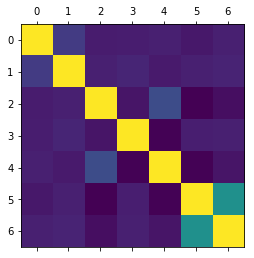

In [6]:
plt.matshow(df.corr())
df.corr()

# Create datasets

In [12]:
RANDOM_STATE = 25

# Get sub-sample to compute things faster
X = pd.concat([df[df['y'] == 'yes'], df[df['y'] == 'no'].sample(int(df.shape[0] / 6), random_state=RANDOM_STATE)])

# Create one-hot encodings of categorical variables
categorical_columns = ['job', 'marital', 'education', 'default',
                       'housing','loan','contact','month','poutcome']
X = pd.get_dummies(X, columns=categorical_columns)
X_df = X.copy()
X_df.drop(columns=['duration'], inplace=True)

# Get y labels as 1 or 0
y = np.where(X['y'] == 'yes', 1, 0)
X.drop(columns=['y', 'duration'], inplace=True)
cols = X.columns

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Counter(y)

Counter({1: 5289, 0: 7535})

### Helper functions

In [13]:
def plot_curves(title, xlabel, ylabel, train_set, test_set, metric_label, ylim_min=0.75):
    plt.plot(train_set, linewidth=3, label='Training ' + metric_label)
    plt.plot(test_set, linewidth=3, label='Test ' + metric_label)
    plt.legend()
    plt.title(title)
    plt.ylim(ylim_min, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()
    
def learning_curve(clf_name, clf, step=5):
    train_auc, test_auc = [], []
    x_step = []
    for i in range(step, 101, step):
        pct = 1.0 * i / 100
        upper = int(X_train.shape[0] * pct) - 1
        X_train_sub = X_train[:upper]
        y_train_sub = y_train[:upper]
        x_step.append(upper)
        
        clf = clf.fit(X_train_sub, y_train_sub)
        train_auc.append(roc_auc_score(y_train_sub, clf.predict_proba(X_train_sub)[:,1]))
        test_auc.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
        
    plt.plot(np.array(x_step), np.array(train_auc), label='Training AUC')
    plt.plot(np.array(x_step), np.array(test_auc), label='Test AUC')
    plt.legend()
    plt.title('Bank ' + clf_name + ' Learning Curves')
    plt.ylim(0.50, 1.0)
    plt.xlabel('# of Samples')
    plt.ylabel('ROC AUC')
    plt.figure(figsize=(12,12))
    plt.show()

def plot_curve(title, xlabel, ylabel, x, y):
    plt.plot(np.array(x), np.array(y))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figure(figsize=(12,12))
    plt.show()

# K-Means

### Model Complexity Curves

In [122]:
max_k = 112
x = []
inertia_scores = []
silhouette_scores = []
completeness_scores = []
homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    x.append(i)
    print(i)
    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X)
    
    inertia_scores.append(clf.inertia_)
    silhouette_scores.append(silhouette_score(X, clf.labels_))
    completeness_scores.append(completeness_score(y, clf.labels_))
    homogeneity_scores.append(homogeneity_score(y, clf.labels_))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


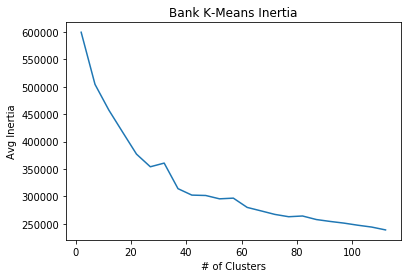

<Figure size 864x864 with 0 Axes>

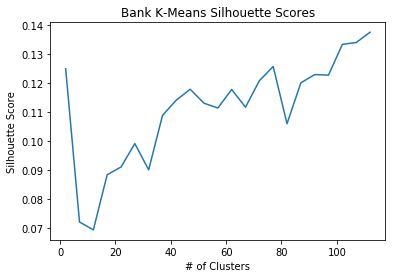

<Figure size 864x864 with 0 Axes>

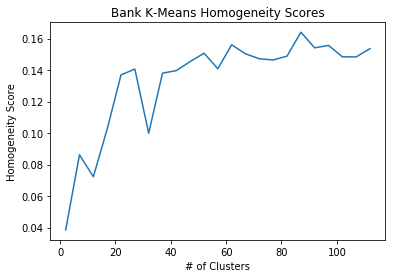

<Figure size 864x864 with 0 Axes>

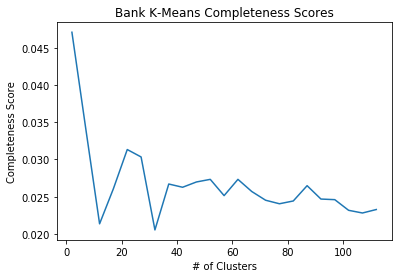

<Figure size 864x864 with 0 Axes>

In [123]:
plot_curve('Bank K-Means Inertia', '# of Clusters', 'Avg Inertia', x, inertia_scores)
plot_curve('Bank K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, silhouette_scores)
plot_curve('Bank K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, homogeneity_scores)
plot_curve('Bank K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, completeness_scores)

# Expectation Minimization

In [76]:
max_k = 112
gmm_x = []
gmm_log_likelihood = []
gmm_silhouette_scores = []
gmm_completeness_scores = []
gmm_homogeneity_scores = []
gmm_aic_scores = []
gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X)
    labels = clf.predict(X)
    
    
    gmm_log_likelihood.append(clf.score(X))
    gmm_silhouette_scores.append(silhouette_score(X, labels))
    gmm_completeness_scores.append(completeness_score(y, labels))
    gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    gmm_aic_scores.append(clf.aic(X))
    gmm_bic_scores.append(clf.bic(X))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


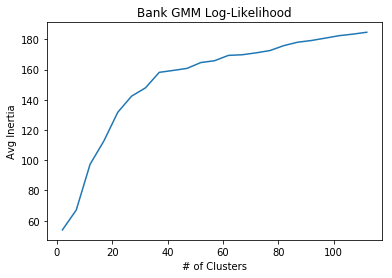

<Figure size 864x864 with 0 Axes>

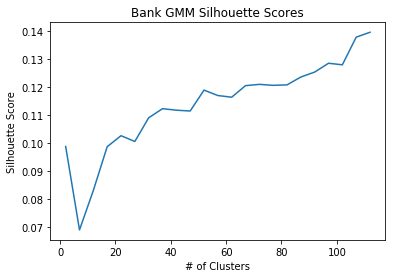

<Figure size 864x864 with 0 Axes>

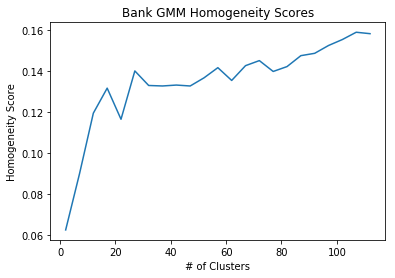

<Figure size 864x864 with 0 Axes>

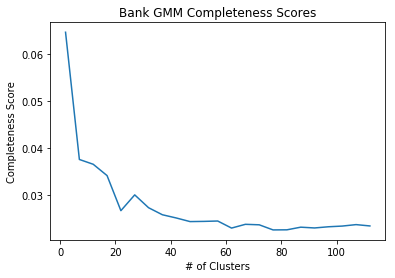

<Figure size 864x864 with 0 Axes>

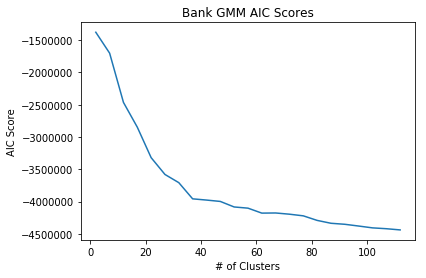

<Figure size 864x864 with 0 Axes>

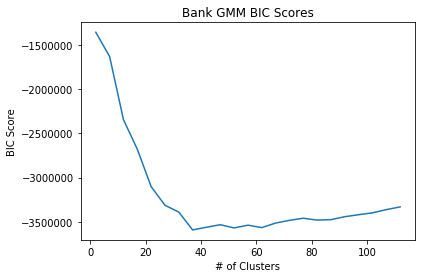

<Figure size 864x864 with 0 Axes>

In [78]:
plot_curve('Bank GMM Log-Likelihood', '# of Clusters', 'Avg Inertia', gmm_x, gmm_log_likelihood)
plot_curve('Bank GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', gmm_x, gmm_silhouette_scores)
plot_curve('Bank GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', gmm_x, gmm_homogeneity_scores)
plot_curve('Bank GMM Completeness Scores', '# of Clusters', 'Completeness Score', gmm_x, gmm_completeness_scores)
plot_curve('Bank GMM AIC Scores', '# of Clusters', 'AIC Score', gmm_x, gmm_aic_scores)
plot_curve('Bank GMM BIC Scores', '# of Clusters', 'BIC Score', gmm_x, gmm_bic_scores)

### Making sense out of the clusters

In [67]:
clf = MiniBatchKMeans(n_clusters=20, random_state=RANDOM_STATE)
clf = clf.fit(X)
X_df['K-means clusters'] = clf.labels_

clf = GaussianMixture(n_components=38, random_state=RANDOM_STATE)
clf = clf.fit(X)
X_df['GMM clusters'] = clf.predict(X)

In [79]:
X_df.groupby('K-means clusters').mean().std() / X_df.groupby('K-means clusters').mean().mean()

age                    0.169587
balance                0.398623
day                    0.190958
campaign               0.209768
pdays                  1.298134
previous               1.257206
job_admin.             1.956808
job_blue-collar        1.338383
job_entrepreneur       1.026577
job_housemaid          4.109319
job_management         1.442683
job_retired            2.733200
job_self-employed      3.835394
job_services           1.172383
job_student            4.113675
job_technician         1.362575
job_unemployed         3.661406
job_unknown            4.472136
marital_divorced       0.399881
marital_married        0.263283
marital_single         0.559219
education_primary      1.368266
education_secondary    0.461420
education_tertiary     0.708018
education_unknown      1.549331
default_no             0.235376
default_yes            4.472136
housing_no             0.424815
housing_yes            0.574092
loan_no                0.250865
loan_yes               1.866788
contact_

### Helper methods for dimensionality reduction data set accuracy analysis

In [9]:
def plot_dim_reduction_acc(x_range, dim_redux, cross_val_acc, title, xlabel, ylabel, dim_redux_label):    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(dim_redux_label)
    ax1.bar(x_range, dim_redux, color='cyan')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Cross-Validation Accuracy')  # we already handled the x-label with ax1
    ax2.plot(x_range, cross_val_acc, color='blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()


def plot_nn_acc(x_range, train_acc, test_acc, title, xlabel):
    plt.plot(x_range, train_acc, linewidth=3, label='Training Accuracy')
    plt.plot(x_range, test_acc, linewidth=3, label='Test Accuracy')
    plt.legend()
    plt.title(title)
    plt.ylim(0.3, 1.0)
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.figure(figsize=(12,12))
    plt.show()

# PCA Analysis

In [15]:
num_components = 50
pca = PCA(n_components=num_components)
pca = pca.fit(X)

### Accuracy analysis - optimum # of components

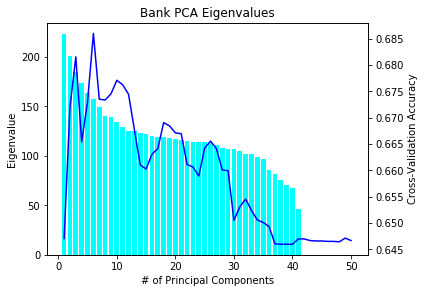

In [16]:
X_dim_redux = pca.transform(X)
max_eigenvalues = X.shape[1]

cross_val_acc = []
x_range = []
for i in range(1, max_eigenvalues + 1):
    x_range.append(i)
    X_sub = X_dim_redux[:, 0:i]
    clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

plot_dim_reduction_acc(x_range, pca.singular_values_, cross_val_acc, 'Bank PCA Eigenvalues', '# of Principal Components',
                       'Eigenvalue', 'Eigenvalue')

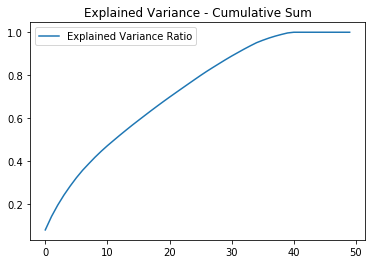

In [17]:
pca_explained_variance = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance Ratio'])
pca_explained_variance.cumsum().plot(title='Explained Variance - Cumulative Sum')

### K-Means on PCA

In [98]:
X_pca = pca.transform(X)[:, 0:5]

max_k = 112
pca_x = []
pca_inertia_scores = []
pca_silhouette_scores = []
pca_completeness_scores = []
pca_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    pca_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_pca)
    
    pca_inertia_scores.append(clf.inertia_)
    pca_silhouette_scores.append(silhouette_score(X, clf.labels_))
    pca_completeness_scores.append(completeness_score(y, clf.labels_))
    pca_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

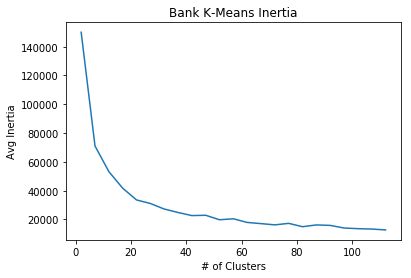

<Figure size 864x864 with 0 Axes>

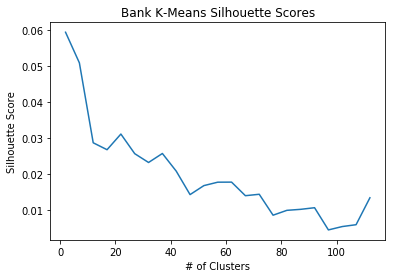

<Figure size 864x864 with 0 Axes>

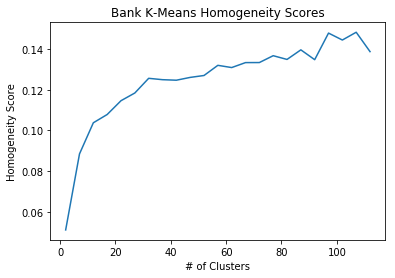

<Figure size 864x864 with 0 Axes>

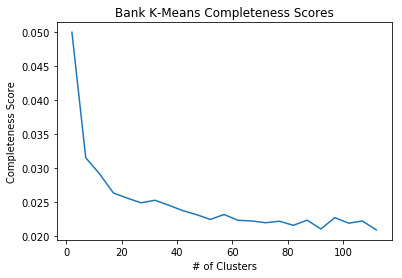

<Figure size 864x864 with 0 Axes>

In [99]:
plot_curve('Bank PCA K-Means Inertia', '# of Clusters', 'Avg Inertia', pca_x, pca_inertia_scores)
plot_curve('Bank K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', pca_x, pca_silhouette_scores)
plot_curve('Bank K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', pca_x, pca_homogeneity_scores)
plot_curve('Bank K-Means Completeness Scores', '# of Clusters', 'Completeness Score', pca_x, pca_completeness_scores)

In [81]:
X_pca = pca.transform(X)[:, 0:5]

max_k = 112
pca_gmm_x = []
pca_gmm_log_likelihood = []
pca_gmm_silhouette_scores = []
pca_gmm_completeness_scores = []
pca_gmm_homogeneity_scores = []
pca_gmm_aic_scores = []
pca_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    pca_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_pca)
    labels = clf.predict(X_pca)
    
    
    pca_gmm_log_likelihood.append(clf.score(X_pca))
    pca_gmm_silhouette_scores.append(silhouette_score(X_pca, labels))
    pca_gmm_completeness_scores.append(completeness_score(y, labels))
    pca_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    pca_gmm_aic_scores.append(clf.aic(X_pca))
    pca_gmm_bic_scores.append(clf.bic(X_pca))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


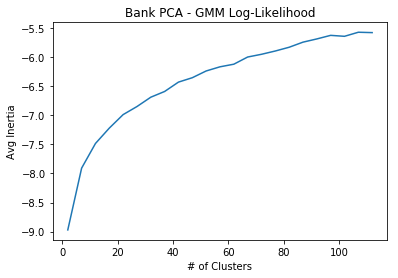

<Figure size 864x864 with 0 Axes>

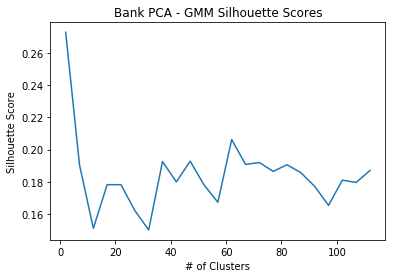

<Figure size 864x864 with 0 Axes>

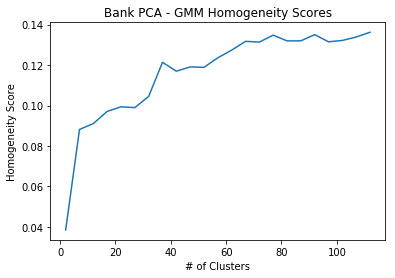

<Figure size 864x864 with 0 Axes>

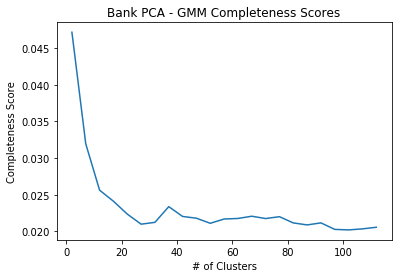

<Figure size 864x864 with 0 Axes>

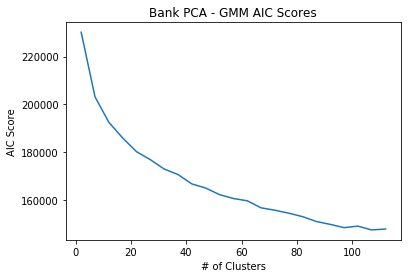

<Figure size 864x864 with 0 Axes>

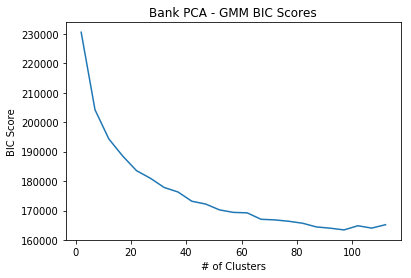

<Figure size 864x864 with 0 Axes>

In [83]:
plot_curve('Bank PCA - GMM Log-Likelihood', '# of Clusters', 'Avg Inertia', pca_gmm_x, pca_gmm_log_likelihood)
plot_curve('Bank PCA - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', pca_gmm_x, pca_gmm_silhouette_scores)
plot_curve('Bank PCA - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', pca_gmm_x, pca_gmm_homogeneity_scores)
plot_curve('Bank PCA - GMM Completeness Scores', '# of Clusters', 'Completeness Score', pca_gmm_x, pca_gmm_completeness_scores)
plot_curve('Bank PCA - GMM AIC Scores', '# of Clusters', 'AIC Score', pca_gmm_x, pca_gmm_aic_scores)
plot_curve('Bank PCA - GMM BIC Scores', '# of Clusters', 'BIC Score', pca_gmm_x, pca_gmm_bic_scores)

### Neural Network Performance

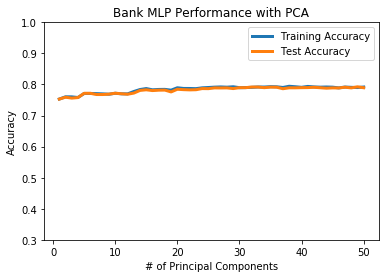

<Figure size 864x864 with 0 Axes>

In [59]:
X_pca = pca.transform(X)
max_eigenvalues = X_pca.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_STATE)

train_acc = []
test_acc = []
x_range = []
for i in range(1, max_eigenvalues + 1):
    x_range.append(i)
    X_train_sub = X_train[:, 0:i]
    X_test_sub = X_test[:, 0:i]
    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)
    clf = clf.fit(X_train_sub, y_train)

    train_acc.append(accuracy_score(y_train, clf.predict(X_train_sub)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test_sub)))

plot_nn_acc(x_range, train_acc, test_acc, 'Bank MLP Performance with PCA', '# of Principal Components')

# ICA Analysis

In [18]:
num_components = 50
ica = FastICA(n_components=num_components, random_state=RANDOM_STATE)
ica = ica.fit(X)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


### Accuracy analysis - optimum # of components

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


10
20
30
40
50


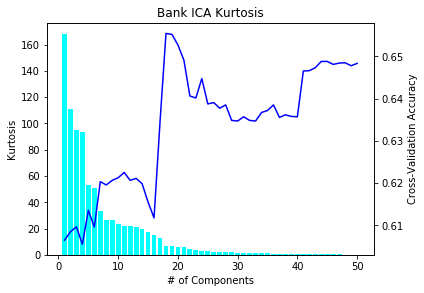

In [19]:
max_components = X.shape[1]
ica = FastICA(n_components=X.shape[1], random_state=RANDOM_STATE, max_iter=500)
ica = ica.fit(X)
X_ica = ica.transform(X)

ica_df = pd.DataFrame(X_ica)
ica_kurtosis = np.absolute(ica_df.kurt(axis=0).as_matrix())
kurt_indexes = ica_kurtosis.argsort()[::-1]

kurt = []
cross_val_acc = []
x_range = []
for i in range(1, max_components + 1):
    if i % 10 == 0:
        print(i)
    
    x_range.append(i)
    X_sub = X_ica[:, kurt_indexes[0:i]]
    
    # Cross-validation accuracy
    clf = DecisionTreeClassifier(max_depth=5, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

plot_dim_reduction_acc(x_range, ica_kurtosis[kurt_indexes], cross_val_acc, 'Bank ICA Kurtosis', '# of Components',
                       'Kurtosis', 'Kurtosis')

### K-Means on ICA

In [22]:
max_k = 112
ica_x = []
ica_inertia_scores = []
ica_silhouette_scores = []
ica_completeness_scores = []
ica_homogeneity_scores = []
X_ica_cluster = X_ica[:, kurt_indexes[0:17]]

for i in range(2, max_k + 1, 5):
    ica_x.append(i)
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_ica_cluster)
    
    ica_inertia_scores.append(clf.inertia_)
    ica_silhouette_scores.append(silhouette_score(X_ica_cluster, clf.labels_))
    ica_completeness_scores.append(completeness_score(y, clf.labels_))
    ica_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

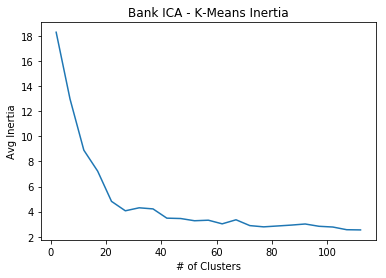

<Figure size 864x864 with 0 Axes>

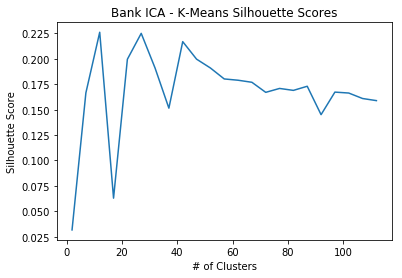

<Figure size 864x864 with 0 Axes>

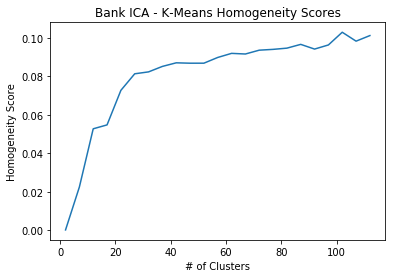

<Figure size 864x864 with 0 Axes>

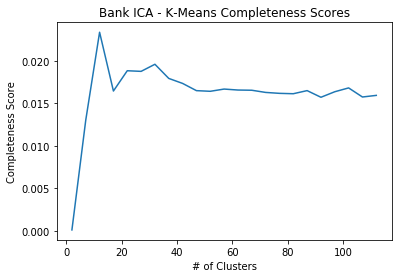

<Figure size 864x864 with 0 Axes>

In [23]:
plot_curve('Bank ICA - K-Means Inertia', '# of Clusters', 'Avg Inertia', ica_x, ica_inertia_scores)
plot_curve('Bank ICA - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', ica_x, ica_silhouette_scores)
plot_curve('Bank ICA - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', ica_x, ica_homogeneity_scores)
plot_curve('Bank ICA - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', ica_x, ica_completeness_scores)

### GMM on ICA

In [24]:
max_k = 112
ica_gmm_x = []
ica_gmm_log_likelihood = []
ica_gmm_silhouette_scores = []
ica_gmm_completeness_scores = []
ica_gmm_homogeneity_scores = []
ica_gmm_aic_scores = []
ica_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    ica_gmm_x.append(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_ica_cluster)
    labels = clf.predict(X_ica_cluster)
        
    ica_gmm_log_likelihood.append(clf.score(X_ica_cluster))
    ica_gmm_silhouette_scores.append(silhouette_score(X_ica_cluster, labels))
    ica_gmm_completeness_scores.append(completeness_score(y, labels))
    ica_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    ica_gmm_aic_scores.append(clf.aic(X_ica_cluster))
    ica_gmm_bic_scores.append(clf.bic(X_ica_cluster))

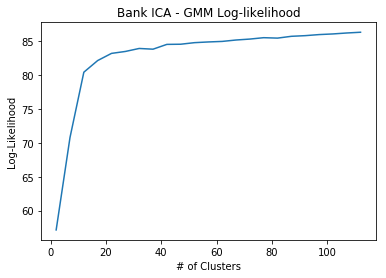

<Figure size 864x864 with 0 Axes>

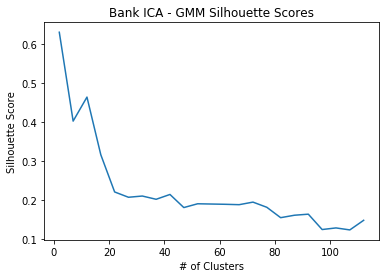

<Figure size 864x864 with 0 Axes>

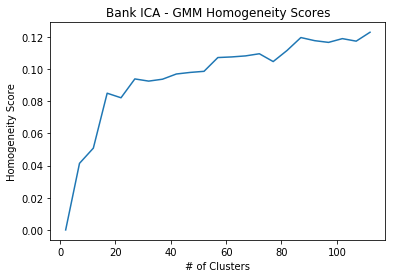

<Figure size 864x864 with 0 Axes>

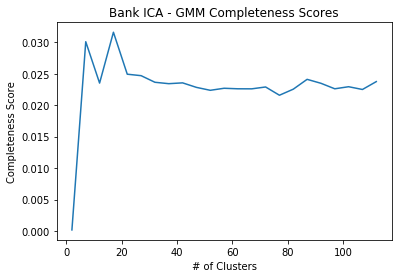

<Figure size 864x864 with 0 Axes>

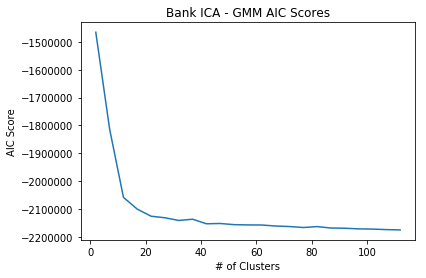

<Figure size 864x864 with 0 Axes>

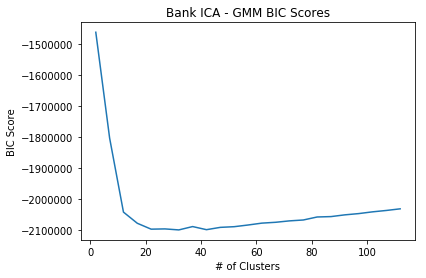

<Figure size 864x864 with 0 Axes>

In [28]:
plot_curve('Bank ICA - GMM Log-likelihood', '# of Clusters', 'Log-Likelihood', ica_gmm_x, ica_gmm_log_likelihood)
plot_curve('Bank ICA - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', ica_gmm_x, ica_gmm_silhouette_scores)
plot_curve('Bank ICA - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', ica_gmm_x, ica_gmm_homogeneity_scores)
plot_curve('Bank ICA - GMM Completeness Scores', '# of Clusters', 'Completeness Score', ica_gmm_x, ica_gmm_completeness_scores)
plot_curve('Bank ICA - GMM AIC Scores', '# of Clusters', 'AIC Score', ica_gmm_x, ica_gmm_aic_scores)
plot_curve('Bank ICA - GMM BIC Scores', '# of Clusters', 'BIC Score', ica_gmm_x, ica_gmm_bic_scores)

# Randomized Projections

In [31]:
num_components = 100
grp = GaussianRandomProjection(n_components=num_components, random_state=24)
grp = grp.fit(X)

/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


### Accuracy analysis - optimum # of components

1


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


2


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


3


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


4


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


5


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (50 < 100).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


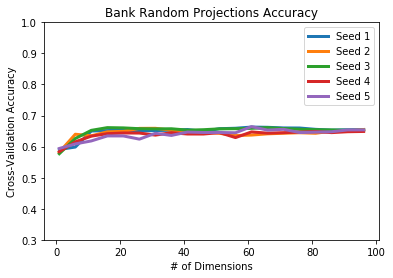

<Figure size 864x864 with 0 Axes>

In [36]:
X_rand = grp.transform(X)
max_components = X_rand.shape[1]

for j in range(1, 6):
    print(j)
    num_components = 100
    grp = GaussianRandomProjection(n_components=num_components, random_state=j)
    grp = grp.fit(X)
    X_rand = grp.transform(X)
    
    cross_val_acc = []
    x_range = []
    for i in range(1, max_components + 1, 5):
        x_range.append(i)
        X_sub = X_rand[:, 0:i]
        clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
        score = cross_val_score(clf, X_sub, y, cv=5).mean()
        cross_val_acc.append(score)

    plt.plot(x_range, cross_val_acc, linewidth=3, label='Seed %d' % j)

plt.title('Bank Random Projections Accuracy')
plt.legend()
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

### K-Means on Randomized Projections

In [157]:
X_rand = grp.transform(X)[:, 0:15]

max_k = 112
rand_x = []
rand_inertia_scores = []
rand_silhouette_scores = []
rand_completeness_scores = []
rand_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    rand_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_rand)
    
    rand_inertia_scores.append(clf.inertia_)
    rand_silhouette_scores.append(silhouette_score(X, clf.labels_))
    rand_completeness_scores.append(completeness_score(y, clf.labels_))
    rand_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

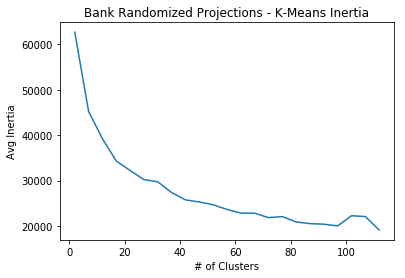

<Figure size 864x864 with 0 Axes>

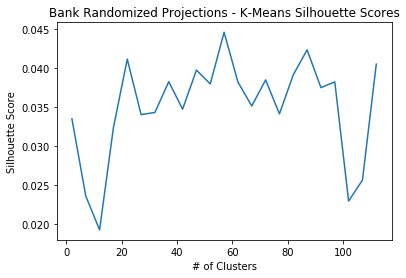

<Figure size 864x864 with 0 Axes>

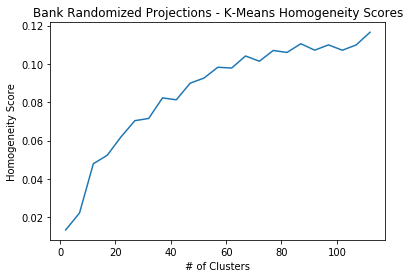

<Figure size 864x864 with 0 Axes>

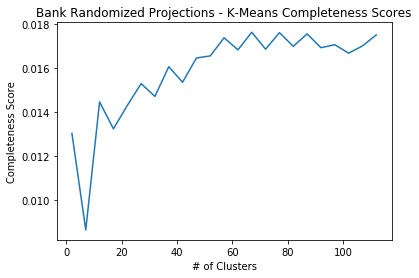

<Figure size 864x864 with 0 Axes>

In [158]:
plot_curve('Bank Randomized Projections - K-Means Inertia', '# of Clusters', 'Avg Inertia', x, rand_inertia_scores)
plot_curve('Bank Randomized Projections - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, rand_silhouette_scores)
plot_curve('Bank Randomized Projections - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, rand_homogeneity_scores)
plot_curve('Bank Randomized Projections - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, rand_completeness_scores)

### GMM on Randomized Projections

In [38]:
X_rand = grp.transform(X)[:, 0:15]

max_k = 112
rand_gmm_x = []
rand_gmm_log_likelihood = []
rand_gmm_silhouette_scores = []
rand_gmm_completeness_scores = []
rand_gmm_homogeneity_scores = []
rand_gmm_aic_scores = []
rand_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    rand_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_rand)
    labels = clf.predict(X_rand)
    
    
    rand_gmm_log_likelihood.append(clf.score(X_rand))
    rand_gmm_silhouette_scores.append(silhouette_score(X_rand, labels))
    rand_gmm_completeness_scores.append(completeness_score(y, labels))
    rand_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    rand_gmm_aic_scores.append(clf.aic(X_rand))
    rand_gmm_bic_scores.append(clf.bic(X_rand))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


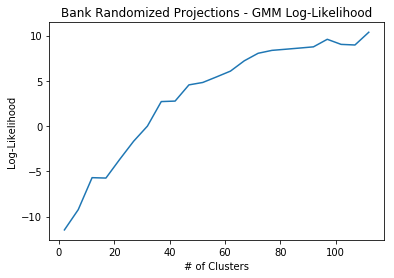

<Figure size 864x864 with 0 Axes>

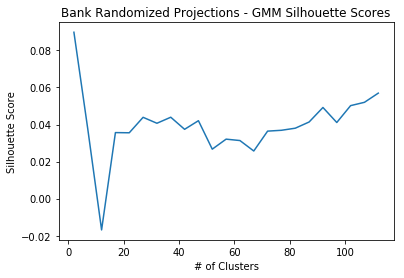

<Figure size 864x864 with 0 Axes>

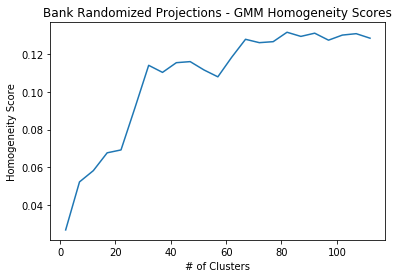

<Figure size 864x864 with 0 Axes>

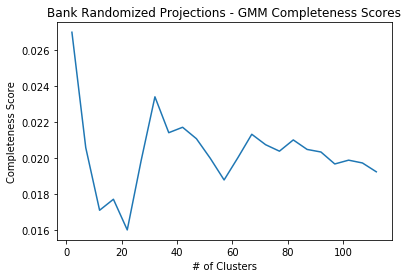

<Figure size 864x864 with 0 Axes>

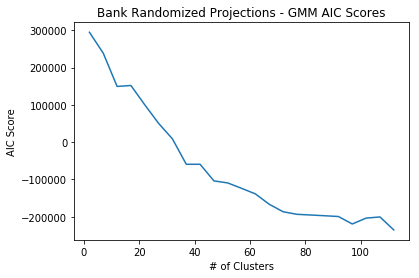

<Figure size 864x864 with 0 Axes>

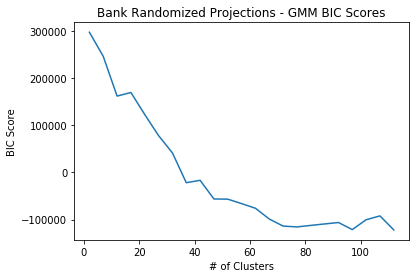

<Figure size 864x864 with 0 Axes>

In [39]:
plot_curve('Bank Randomized Projections - GMM Log-Likelihood', '# of Clusters', 'Log-Likelihood', rand_gmm_x, rand_gmm_log_likelihood)
plot_curve('Bank Randomized Projections - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', rand_gmm_x, rand_gmm_silhouette_scores)
plot_curve('Bank Randomized Projections - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', rand_gmm_x, rand_gmm_homogeneity_scores)
plot_curve('Bank Randomized Projections - GMM Completeness Scores', '# of Clusters', 'Completeness Score', rand_gmm_x, rand_gmm_completeness_scores)
plot_curve('Bank Randomized Projections - GMM AIC Scores', '# of Clusters', 'AIC Score', rand_gmm_x, rand_gmm_aic_scores)
plot_curve('Bank Randomized Projections - GMM BIC Scores', '# of Clusters', 'BIC Score', rand_gmm_x, rand_gmm_bic_scores)

# Feature Selection - Filtering

In [40]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=20)
feature_selector = feature_selector.fit(X, y)

### Accuracy analysis - optimum # of components

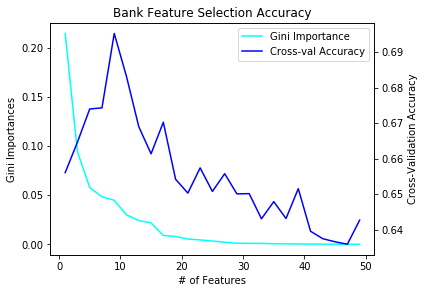

In [42]:
max_components = X.shape[1]

cross_val_acc = []
feature_importances = []
x_range = []
for i in range(1, max_components + 1, 2):
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fselect = feature_selector.transform(X)
    
    x_range.append(i)
    X_sub = X_fselect[:, 0:i]
    clf = DecisionTreeClassifier(max_depth=6, criterion='gini')
    score = cross_val_score(clf, X_sub, y, cv=5).mean()
    cross_val_acc.append(score)

# gini importances
temp_importances = np.array(feature_selector.model.feature_importances_)
temp_importances.sort()
sorted_importances = np.flip(temp_importances)
importances_to_chart = sorted_importances[[i - 1 for i in range(1, max_components + 1, 2)]]
    
fig, ax1 = plt.subplots()

ax1.set_xlabel('# of Features')
ax1.set_ylabel('Gini Importances')
ln1 = ax1.plot(x_range, importances_to_chart, color='cyan', label='Gini Importance')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Cross-Validation Accuracy')  # we already handled the x-label with ax1
ln2 = ax2.plot(x_range, cross_val_acc, color='blue', label='Cross-val Accuracy')

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Bank Feature Selection Accuracy')
plt.show()

### K-Means on Feature Selection

In [221]:
rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=10)
feature_selector = feature_selector.fit(X, y)
X_fs = feature_selector.transform(X)

max_k = 112
fs_x = []
fs_inertia_scores = []
fs_silhouette_scores = []
fs_completeness_scores = []
fs_homogeneity_scores = []

for i in range(2, max_k + 1, 5):
    fs_x.append(i)    
    clf = MiniBatchKMeans(n_clusters=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_fs)
    
    fs_inertia_scores.append(clf.inertia_)
    fs_silhouette_scores.append(silhouette_score(X, clf.labels_))
    fs_completeness_scores.append(completeness_score(y, clf.labels_))
    fs_homogeneity_scores.append(homogeneity_score(y, clf.labels_))

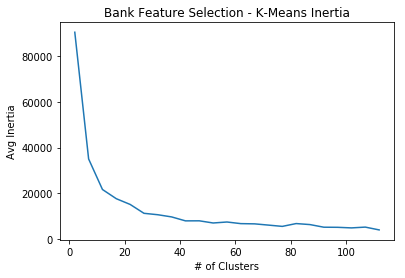

<Figure size 864x864 with 0 Axes>

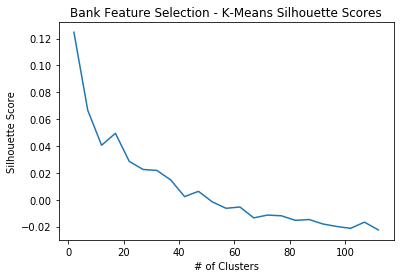

<Figure size 864x864 with 0 Axes>

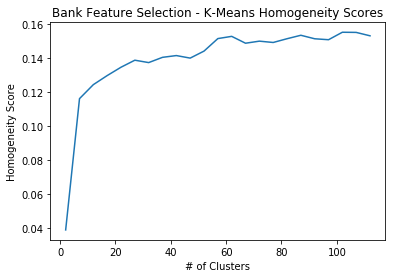

<Figure size 864x864 with 0 Axes>

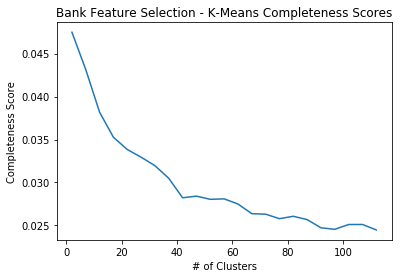

<Figure size 864x864 with 0 Axes>

In [222]:
plot_curve('Bank Feature Selection - K-Means Inertia', '# of Clusters', 'Avg Inertia', x, fs_inertia_scores)
plot_curve('Bank Feature Selection - K-Means Silhouette Scores', '# of Clusters', 'Silhouette Score', x, fs_silhouette_scores)
plot_curve('Bank Feature Selection - K-Means Homogeneity Scores', '# of Clusters', 'Homogeneity Score', x, fs_homogeneity_scores)
plot_curve('Bank Feature Selection - K-Means Completeness Scores', '# of Clusters', 'Completeness Score', x, fs_completeness_scores)

### GMM on Feature Selection

In [46]:
rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
feature_selector = ImportanceSelector(rfc, n=10)
feature_selector = feature_selector.fit(X, y)
X_fs = feature_selector.transform(X)

max_k = 112
fs_gmm_x = []
fs_gmm_log_likelihood = []
fs_gmm_silhouette_scores = []
fs_gmm_completeness_scores = []
fs_gmm_homogeneity_scores = []
fs_gmm_aic_scores = []
fs_gmm_bic_scores = []

for i in range(2, max_k + 1, 5):
    fs_gmm_x.append(i)
    print(i)
    
    clf = GaussianMixture(n_components=i, random_state=RANDOM_STATE)
    clf = clf.fit(X_fs)
    labels = clf.predict(X_fs)
    
    
    fs_gmm_log_likelihood.append(clf.score(X_fs))
    fs_gmm_silhouette_scores.append(silhouette_score(X_fs, labels))
    fs_gmm_completeness_scores.append(completeness_score(y, labels))
    fs_gmm_homogeneity_scores.append(homogeneity_score(y, labels))
    fs_gmm_aic_scores.append(clf.aic(X_fs))
    fs_gmm_bic_scores.append(clf.bic(X_fs))

2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92
97
102
107
112


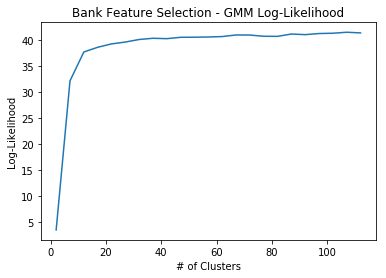

<Figure size 864x864 with 0 Axes>

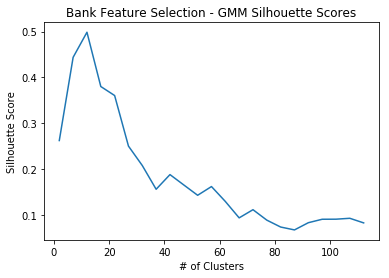

<Figure size 864x864 with 0 Axes>

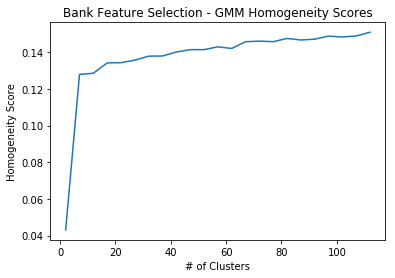

<Figure size 864x864 with 0 Axes>

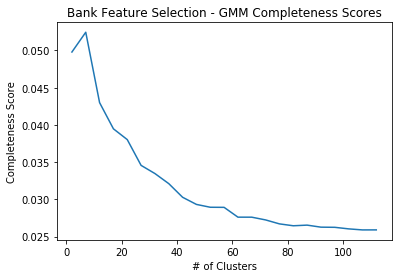

<Figure size 864x864 with 0 Axes>

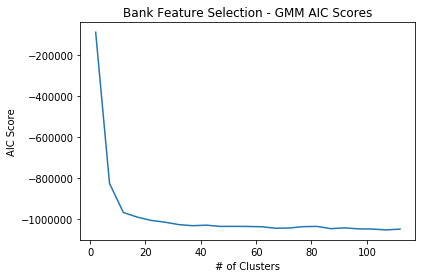

<Figure size 864x864 with 0 Axes>

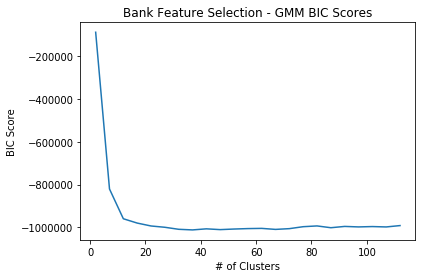

<Figure size 864x864 with 0 Axes>

In [47]:
plot_curve('Bank Feature Selection - GMM Log-Likelihood', '# of Clusters', 'Log-Likelihood', fs_gmm_x, fs_gmm_log_likelihood)
plot_curve('Bank Feature Selection - GMM Silhouette Scores', '# of Clusters', 'Silhouette Score', fs_gmm_x, fs_gmm_silhouette_scores)
plot_curve('Bank Feature Selection - GMM Homogeneity Scores', '# of Clusters', 'Homogeneity Score', fs_gmm_x, fs_gmm_homogeneity_scores)
plot_curve('Bank Feature Selection - GMM Completeness Scores', '# of Clusters', 'Completeness Score', fs_gmm_x, fs_gmm_completeness_scores)
plot_curve('Bank Feature Selection - GMM AIC Scores', '# of Clusters', 'AIC Score', fs_gmm_x, fs_gmm_aic_scores)
plot_curve('Bank Feature Selection - GMM BIC Scores', '# of Clusters', 'BIC Score', fs_gmm_x, fs_gmm_bic_scores)

# Neural Network Performance

In [17]:
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

### Dimensionality Reduction

In [48]:
max_components = X.shape[1]

nn_x_range = []

pca_nn_acc = []
ica_nn_acc = []
rand_nn_acc = []
fs_nn_acc = []

for i in range(1, max_components + 1, 4):
    print(i)
    nn_x_range.append(i)
    
    pca = PCA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_pca = pca.transform(X)
    
    ica = FastICA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_ica = ica.transform(X)
    
    grp = GaussianRandomProjection(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_rand = grp.transform(X)
    
    rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fs = feature_selector.transform(X)

    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)

    pca_nn_acc.append(cross_val_score(clf, X_pca, y, cv=4).mean())
    ica_nn_acc.append(cross_val_score(clf, X_ica, y, cv=4).mean())
    rand_nn_acc.append(cross_val_score(clf, X_rand, y, cv=4).mean())
    fs_nn_acc.append(cross_val_score(clf, X_fs, y, cv=4).mean())

1


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

5


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

9


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

13


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

17


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

21


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

25


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

29


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

33


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

37


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optim

41


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

45


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

49


/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/7001695/gtech/machine-learning/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Opti

ValueError: x and y must have same first dimension, but have shapes (25,) and (13,)

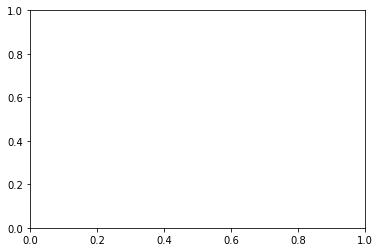

In [49]:
nn_x_range = x_range
plt.plot(x_range, pca_nn_acc, linewidth=3, label='PCA')
plt.plot(x_range, ica_nn_acc, linewidth=3, label='ICA')
plt.plot(x_range, rand_nn_acc, linewidth=3, label='Randomized Projections')
plt.plot(x_range, fs_nn_acc, linewidth=3, label='Feature Selection')
plt.legend()
plt.title('Telco Neural Network Performance')
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

## Dimensionality Reduction and Clustering

In [57]:
def augment_dataset_with_clusters(X, k):
    # K-means
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X)
    km_labels = km.labels_.reshape(-1, 1)
    
    enc = OneHotEncoder()
    enc = enc.fit(km_labels)
    km_onehot = enc.transform(km_labels).todense()
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE).fit(X)
    gmm_proba = gmm.predict_proba(X)

    return np.hstack((km_onehot, gmm_proba))

In [ ]:
max_components = X.shape[1]

train_acc = []
test_acc = []
x_range = []

pca_nn_acc = []
ica_nn_acc = []
rand_nn_acc = []
fs_nn_acc = []

for i in range(2, max_components + 1, 100):
    print(i)
    x_range.append(i)
    
    pca = PCA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_pca = pca.transform(X)
    
    ica = FastICA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_ica = ica.transform(X)
    
    grp = GaussianRandomProjection(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_rand = grp.transform(X)
    
    rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fs = feature_selector.transform(X)

    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)

    pca_nn_acc.append(cross_val_score(clf, X_pca, y, cv=4).mean())
    ica_nn_acc.append(cross_val_score(clf, X_ica, y, cv=4).mean())
    rand_nn_acc.append(cross_val_score(clf, X_rand, y, cv=4).mean())
    fs_nn_acc.append(cross_val_score(clf, X_fs, y, cv=4).mean())

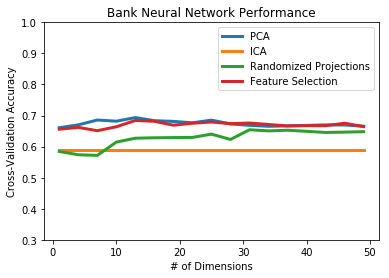

<Figure size 864x864 with 0 Axes>

In [58]:
plt.plot(x_range, pca_nn_acc, linewidth=3, label='PCA')
plt.plot(x_range, ica_nn_acc, linewidth=3, label='ICA')
plt.plot(x_range, rand_nn_acc, linewidth=3, label='Randomized Projections')
plt.plot(x_range, fs_nn_acc, linewidth=3, label='Feature Selection')
plt.legend()
plt.title('Bank Neural Network Performance')
plt.ylim(0.3, 1.0)
plt.xlabel('# of Dimensions')
plt.ylabel('Cross-Validation Accuracy')
plt.figure(figsize=(12,12))
plt.show()

In [56]:
def augment_dataset_with_clusters(X, k):
    # K-means
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X)
    km_labels = km.labels_.reshape(-1, 1)
    
    enc = OneHotEncoder()
    enc = enc.fit(km_labels)
    km_onehot = enc.transform(km_labels).todense()
    
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE).fit(X)
    gmm_proba = gmm.predict_proba(X)

    return np.hstack((km_onehot, gmm_proba))

In [51]:
max_components = X.shape[1]

train_acc = []
test_acc = []
x_range = []

pca_nn_acc = []
ica_nn_acc = []
rand_nn_acc = []
fs_nn_acc = []

for i in range(2, max_components + 1, 100):
    print(i)
    x_range.append(i)
    
    pca = PCA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_pca = pca.transform(X)
    
    ica = FastICA(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_ica = ica.transform(X)
    
    grp = GaussianRandomProjection(n_components=i, random_state=RANDOM_STATE).fit(X)
    X_rand = grp.transform(X)
    
    rfc = RandomForestClassifier(max_depth=4, n_estimators=20)
    feature_selector = ImportanceSelector(rfc, n=i)
    feature_selector = feature_selector.fit(X, y)
    X_fs = feature_selector.transform(X)

    clf = MLPClassifier(solver='adam', alpha=1.0, activation='relu', batch_size=20,
                learning_rate='constant', random_state=RANDOM_STATE,
                hidden_layer_sizes=(30), max_iter=10)

    pca_nn_acc.append(cross_val_score(clf, X_pca, y, cv=4).mean())
    ica_nn_acc.append(cross_val_score(clf, X_ica, y, cv=4).mean())
    rand_nn_acc.append(cross_val_score(clf, X_rand, y, cv=4).mean())
    fs_nn_acc.append(cross_val_score(clf, X_fs, y, cv=4).mean())

In [52]:
km_onehot.shape

(12824, 89)